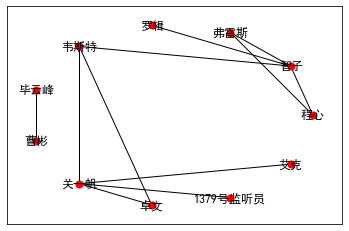

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

plt.rcParams['font.sans-serif']=['SimHei']

plt.rcParams['axes.unicode_minus'] = False

# 加载“威慑纪元”的人物关系数据
afdeter_relation_path = '.\\数据\\person_relationships0/威慑后.csv'  # 替换为实际文件路径
afdeter_count_path = '.\\数据\\new_person_counts/威慑后.csv'  # 替换为人物出场次数数据文件路径


# 读取人物关系数据
afdeter_data = pd.read_csv(afdeter_relation_path, encoding='GBK')
# 读取人物出场次数数据
afdeter_counts = pd.read_csv(afdeter_count_path, encoding='GBK')

# 创建网络图
G_afdeter = nx.Graph()
for _, row in afdeter_data.iterrows():
    G_afdeter.add_edge(row['Person1'], row['Person2'], weight=row['realtionships'])

# 将出场次数添加为节点属性
count_dict = afdeter_counts.set_index('Person')['count'].to_dict()
for node in G_afdeter.nodes():
    G_afdeter.nodes[node]['count'] = count_dict.get(node, 1)  # 默认值为1
    
pos = nx.circular_layout(G_afdeter)
nx.draw_networkx(G_afdeter, pos, with_labels=True, node_size=50, node_color ='red')

In [ ]:
#中心性的度量
deg=G_afdeter.degree
sorted(dict(deg).items(), key=lambda kv: (-kv[1], kv[0]))[:10] ## display a histogram of node degrees          
#点度中心度
degree_centrality = nx.degree_centrality(G_afdeter)
sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[:10]
#介数中心性
betweenness_centrality = nx.betweenness_centrality(G_afdeter)
sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[:10]

#紧密中心性
closeness_centrality = nx.closeness_centrality(G_afdeter)
sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)[:10]
#特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(G_afdeter)
sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True)[:10]
#pagerank算法
pagerank = nx.pagerank(G_afdeter, alpha=0.85)
sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]


In [ ]:
#链接预测
#公共邻居
preds = nx.common_neighbor_centrality(G_afdeter, alpha=1)
sorted(preds, key=lambda x:x[2], reverse=True)[:10]  
#jaccard系数
preds = nx.jaccard_coefficient(G_afdeter)
sorted(preds, key=lambda x:x[2], reverse=True)[:10]
#资源分配指数
preds = nx.resource_allocation_index(G_afdeter)
sorted(preds, key=lambda x:x[2], reverse=True)[:10]
#AA指数
preds = nx.adamic_adar_index(G_afdeter)
sorted(preds, key=lambda x:x[2], reverse=True)[:10] 
#优先链接
preds = nx.preferential_attachment(G_afdeter)
sorted(preds, key=lambda x:x[2], reverse=True)[:10]  



In [ ]:
#社交网络密度
density = nx.density(G_afdeter) 
print("社交网络密度为：",density)

In [ ]:
#社区发现
#连通分量
nx.number_connected_components(G_afdeter)
for i in nx.connected_components(G_afdeter):#计算每个连通分量节点数量
    print(len(i))
# 连通分量按照节点数量排序，取最大的连通分量
c = sorted(nx.connected_components(G_afdeter), key=lambda x:len(x), reverse=True)[0]    
#绘制最大连通分量的子图    
cc = G_afdeter.subgraph(c)
nx.draw_networkx(cc, with_labels=True) 

In [ ]:
#聚集系数
clustering = nx.clustering(cc)
sorted(clustering.items(), key = lambda x:x[1], reverse=True)[:10]

In [ ]:
社区发现
def set_node_community(G, communities):
    for c, v_c in enumerate(communities):
        for v in v_c:
            G.nodes[v]['community'] = c+1

def set_edge_community(G):
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n-1)
    g = low + span * (((i + g_off) * 5) % n) / (n-1)
    b = low + span * (((i + b_off) * 7) % n) / (n-1)
    return (r, g, b)

def draw_community(G, communities):
    set_node_community(G, communities)
    set_edge_community(G)
    external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
    # internal_color = [get_color(GU.nodes[v]['community']) for v in GU.nodes]
    internal_color = [get_color(G.edges[e]['community']) for e in internal]
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G, pos=pos, node_size=0, edgelist=external, edge_color='#ff3333')
    nx.draw_networkx(G, pos=pos, node_color=node_color, edgelist=internal, edge_color=internal_color)


In [ ]:

#基于层次的聚类
#GN算法
from networkx.algorithms.community import girvan_newman
gn_communities = girvan_newman(G_afdeter)
gn_communities = list(gn_communities)[0]
gn_communities
draw_community(G_afdeter, gn_communities)
from networkx.algorithms.community import modularity
modularity(G_afdeter, gn_communities)

In [ ]:
#基于凝聚的算法
#贪婪模块度算法
from networkx.algorithms.community import naive_greedy_modularity_communities

gm_communities = naive_greedy_modularity_communities(G_afdeter)
gm_communities = list(gm_communities)
gm_communities
draw_community(G_afdeter, gm_communities)
from networkx.algorithms.community import modularity
modularity(G_afdeter, gm_communities)

In [ ]:
#louvain算法
from networkx.algorithms.community import louvain_communities
lv_communities = sorted(louvain_communities(G_afdeter), key=len, reverse=True)
lv_communities  
draw_community(G_afdeter, lv_communities) 
from networkx.algorithms.community import modularity
modularity(G_afdeter, lv_communities)


In [ ]:
#标签传播法
from networkx.algorithms.community import label_propagation

lp_communities = label_propagation.label_propagation_communities(G_afdeter)
lp_communities = list(lp_communities)
lp_communities
draw_community(G_afdeter, lp_communities)
from networkx.algorithms import community
community.modularity(G_afdeter, lp_communities)              
